In [2]:
import os
import sys
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.feature_selection import GenericUnivariateSelect, RFE
from sklearn import metrics
from sklearn import linear_model, decomposition, datasets
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression
import seaborn as sns # More snazzy plotting library
import itertools
from itertools import  product
import pprint
from sklearn.ensemble import ExtraTreesRegressor
from multiprocessing import Process, Value, Array
from asyncio import Queue
from threading import Thread
import pickle
import shutil
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
path_full = "../../dataset/no_imdb_names-count_cat-tf_184.csv"
path_train = "../../dataset/no_imdb_names-count_cat-tf_184f_train.csv"
path_test = "../../dataset/no_imdb_names-count_cat-tf_184f_test.csv"

dta_full = pd.read_csv(path_full)
dta_full = dta_full.fillna(value=0, axis=1)
dta_full = dta_full.dropna()
dta_full = dta_full.drop('Unnamed: 0', axis=1)

dta_train = pd.read_csv(path_train)
dta_train = dta_train.fillna(value=0, axis=1)
dta_train = dta_train.dropna()
dta_train = dta_train.drop('Unnamed: 0', axis=1)

dta_test = pd.read_csv(path_test)
dta_test = dta_test.fillna(value=0, axis=1)
dta_test = dta_test.dropna()
dta_test = dta_test.drop('Unnamed: 0', axis=1)

In [6]:
pw = 6
def log_poly(X):
    #hardcoe for this test
    global pw
    #do log
    df_t = pd.DataFrame(X[:,:10])
    X_t = df_t.replace(0, 1/math.e)
    log_res = np.log(X_t)
    
    #do poly
    vector = X[:,10:]
    res    = X[:,:10]
    X      = X[:,:10]
    for power in range(2,pw + 1):
        res = np.concatenate((res, np.power(X, power)), axis=1)
    res_poly_log = np.concatenate((res, log_res), axis=1)
    
    #return conat results
    return np.concatenate((res_poly_log, vector), axis=1)

LogPolynomialTransformer = FunctionTransformer(log_poly)

preprocessor = LogPolynomialTransformer

transfomer = StandardScaler()

reducer = RFE(ExtraTreesRegressor(), step=0.1, n_features_to_select =round((dta_train.shape[1] + (pw -1) *10)*0.33) )

model_reg = GradientBoostingRegressor(learning_rate=0.1, max_depth=10, n_estimators=1000)

pipe_reg = Pipeline(steps=[('preprocessor', preprocessor), ('transfomer', transfomer), ('reducer', reducer),  ('regressor', model_reg)])

In [8]:
x_train = dta_train.drop('worldwide_gross', axis=1)
y_train_reg = dta_train['worldwide_gross']

x_test = dta_test.drop('worldwide_gross', axis=1)
y_test_reg = dta_test['worldwide_gross']

scores_reg = cross_val_score(pipe_reg ,x_train, y_train_reg, cv=5)
print("Scores_reg:" + str(scores_reg))
print(scores_reg.mean())
print()

##------
model_reg =  pipe_reg.fit(x_train, y_train_reg)
print("model_train_reg.score_train:" + str(model_reg.score(x_train,y_train_reg)))


##------
print("model_test_reg.score_test:" + str(model_reg.score(x_test,y_test_reg)))
print()


##------
model_test_grtb_reg =  GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=200).fit(x_train, y_train_reg)
print("model_test_grtb_reg_train:" + str(model_test_grtb_reg.score(x_train,y_train_reg)))
print("model_test_grtb_reg_test:" + str(model_test_grtb_reg.score(x_test,y_test_reg)))
print()

Scores_reg:[ 0.495502    0.63565745  0.53757207  0.50913218  0.47523706]
0.53062015307

model_train_reg.score_train:0.999999999978
model_test_reg.score_test:0.581410451006

model_test_grtb_reg_train:0.786149701331
model_test_grtb_reg_test:0.64660429962



Index(['production_budget', 'duration', 'cast_total_facebook_likes',
       'title_year', 'actor_3_facebook_likes', 'director_facebook_likes'],
      dtype='object')


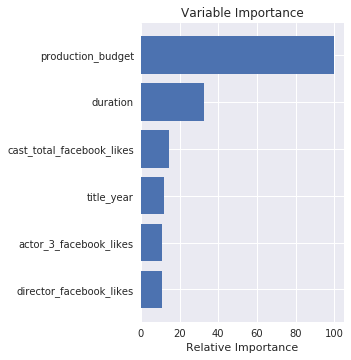

In [8]:
####Feature importance
feature_importance = model_test_grtb_reg.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# A threshold below which to drop features from the final data set. Specifically, this number represents
# the percentage of the most important feature's importance value
fi_threshold = 10 

# Get the indexes of all features over the importance threshold
important_idx = np.where(feature_importance > fi_threshold)[0]

# Create a list of all the feature names above the importance threshold
important_features = x_train.columns[important_idx]

# Get the sorted indexes of important features
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
print(important_features[sorted_idx])

import matplotlib.pyplot as plt
# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, important_features[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.draw()
plt.show()

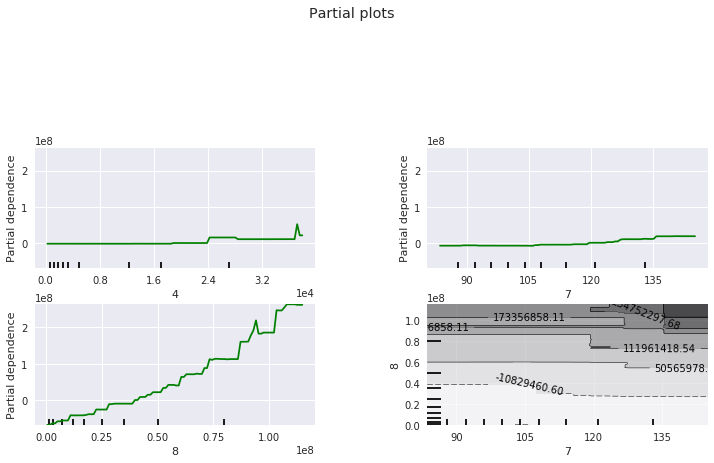

In [22]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

model_test_grtb_reg =  GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=200).fit(x_train, y_train_reg)

fig, axs = plot_partial_dependence(model_test_grtb_reg, x_train, [4, 7, 8, (7, 8)], figsize=(11,7),n_cols=2)

fig.suptitle("Partial plots")
plt.show()

In [9]:
##------
df_1_train = dta_train[dta_train["worldwide_gross"] < 10000000]
X_1_train = df_1_train.drop('worldwide_gross', axis=1)
y_1_train = df_1_train['worldwide_gross']

df_1_test = dta_test[dta_test["worldwide_gross"] < 10000000]
X_1_test = df_1_test.drop('worldwide_gross', axis=1)
y_1_test = df_1_test['worldwide_gross']


df_2_train = dta_train[dta_train["worldwide_gross"] >= 10000000]
df_2_train = df_2_train[df_2_train["worldwide_gross"] < 300000000]
X_2_train = df_2_train.drop('worldwide_gross', axis=1)
y_2_train = df_2_train['worldwide_gross']

df_2_test = dta_test[dta_train["worldwide_gross"] >= 10000000]
df_2_test = df_2_test[df_2_test["worldwide_gross"] < 300000000]
X_2_test = df_2_test.drop('worldwide_gross', axis=1)
y_2_test = df_2_test['worldwide_gross']

df_3_train = dta_train[dta_train["worldwide_gross"] >= 300000000]
X_3_train = df_3_train.drop('worldwide_gross', axis=1)
y_3_train = df_3_train['worldwide_gross']

df_3_test = dta_test[dta_test["worldwide_gross"] >= 300000000]
X_3_test = df_3_test.drop('worldwide_gross', axis=1)
y_3_test = df_3_test['worldwide_gross']


model_1 =  GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=200).fit(X_1_train, y_1_train)
print("model_1_train:" + str(model_1.score(X_1_train,y_1_train)))
print("model_1_test:" + str(model_1.score(X_1_test,y_1_test)))
print('############################')
model_2 =  GradientBoostingRegressor().fit(X_2_train, y_2_train)
print("model_2_train:" + str(model_2.score(X_2_train,y_2_train)))
print("model_2_test:" + str(model_2.score(X_2_test,y_2_test)))
print('############################')
model_3 =  GradientBoostingRegressor().fit(X_3_train, y_3_train)
print("model_3_train:" + str(model_3.score(X_3_train,y_3_train)))
print("model_3_test:" + str(model_3.score(X_3_test,y_3_test)))
print('############################')

model_1_train:0.550063404831
model_1_test:0.333065524042
############################
model_2_train:0.486610018717
model_2_test:0.377358171203
############################
model_3_train:0.807096287635
model_3_test:0.410907159113
############################


/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function staged_decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


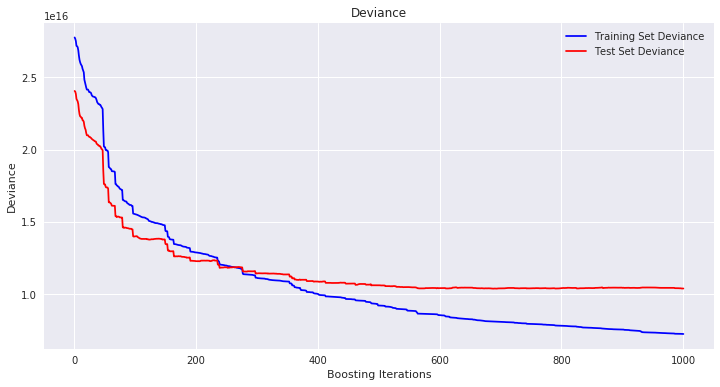

In [38]:
import matplotlib.pyplot as plt

params = {'n_estimators': 1000, 'max_depth': 10,
'learning_rate': 0.1, 'min_samples_leaf':5, 'max_features':0.01, 'max_leaf_nodes':None}

clf = GradientBoostingRegressor(**params).fit(x_train, y_train_reg)

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(x_test)):
    test_score[i] = clf.loss_(y_test_reg, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
                label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
                label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

train_sizes_l
[ 384 1250 2116 2982 3849]
train_scores_mean_l
[ 0.92286973  0.8274427   0.79004374  0.77257101  0.75385605]
train_scores_std_l
[ 0.02905152  0.01835981  0.0138785   0.01003331  0.00196684]
valid_scores_mean_l
[ 0.50950638  0.54598591  0.59005607  0.61138171  0.61109064]
valid_scores_std_l
[ 0.06900304  0.02875408  0.03460461  0.02670612  0.02687697]


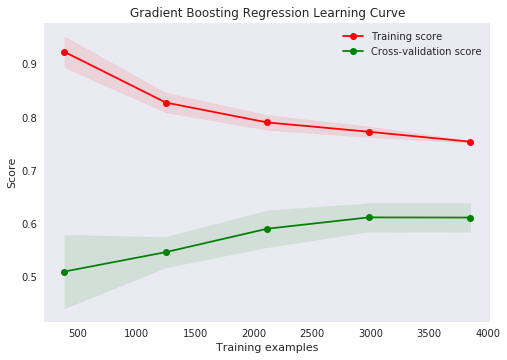

In [17]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
x_train_f = dta_full.drop('worldwide_gross', axis=1)
y_train_cl_f = dta_full.worldwide_gross#.apply (lambda gross: label_gross_3 (gross))
train_sizes_l, train_scores_l, valid_scores_l = learning_curve(GradientBoostingRegressor(), 
                        x_train_f, y_train_cl_f,cv = cv, n_jobs=-1)

train_scores_mean_l = np.mean(train_scores_l, axis=1)
train_scores_std_l = np.std(train_scores_l, axis=1)
valid_scores_mean_l = np.mean(valid_scores_l, axis=1)
valid_scores_std_l = np.std(valid_scores_l, axis=1)

print('train_sizes_l')
print(train_sizes_l)
print('train_scores_mean_l')
print(train_scores_mean_l)
print('train_scores_std_l')
print(train_scores_std_l)
print('valid_scores_mean_l')
print(valid_scores_mean_l)
print('valid_scores_std_l')
print(valid_scores_std_l)

plt.figure()
plt.title("Gradient Boosting Regression Learning Curve")
#plt.ylim(0.7, 1.01)
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()

plt.fill_between(train_sizes_l, train_scores_mean_l - train_scores_std_l,
                 train_scores_mean_l + train_scores_std_l, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_l, valid_scores_mean_l - valid_scores_std_l,
                 valid_scores_mean_l + valid_scores_std_l, alpha=0.1, color="g")
plt.plot(train_sizes_l, train_scores_mean_l, 'o-', color="r",  
          label="Training score")
plt.plot(train_sizes_l, valid_scores_mean_l, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [12]:

from sklearn.datasets import load_digits
x_train = dta_train.drop('worldwide_gross', axis=1)

x_train_trn = pipe_reg.fit_transform(x_train,y_train_reg)

import pylab
NUM_COLORS = 22
cm = pylab.get_cmap('gist_rainbow')
cgen = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

def plot_validation_curve(train_scores, valid_scores,case, lvl):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    print('train_scores_mean')
    print(train_scores_mean)
    
    print('train_scores_std')
    print(train_scores_std)
    
    print('valid_scores_mean')
    print(valid_scores_mean)
    
    print('valid_scores_std')
    print(valid_scores_std)
    
    
    plt.title("Validation Curve with GradientBoostingRegressor")
    plt.xlabel("n_estimators")
    plt.ylabel("Score")
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Train score " + case, 
                   color=cgen[0 + 2*lvl], lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color=cgen[0 + 2*lvl], lw=lw)
    plt.semilogx(param_range, valid_scores_mean, label="CV score," + case,
                    color=cgen[10 + 2*lvl], lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                    valid_scores_mean + valid_scores_std, alpha=0.2,
                    color=cgen[10 + 2*lvl], lw=lw)          
    
    plt.legend(loc="best")
    

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [29]:
x_train_trn.shape

(3784, 40)

In [32]:
from sklearn.model_selection import validation_curve 

param_range = [1, 10, 100, 500, 1000, 3000, 5000, 10000, 15000, 20000]

train_scores_l1, valid_scores_l1 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)
train_scores_l2, valid_scores_l2 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                   
train_scores_l3, valid_scores_l3 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                                                                      

train_scores_mean
[ 0.09191764  0.52711342  0.89843481  0.99780754  0.99997314  1.          1.
  1.          1.          1.        ]
train_scores_std
[  1.83120545e-02   2.73031722e-02   9.33750591e-03   6.18246961e-05
   3.75728181e-06   1.03593075e-11   4.69192387e-15   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.07743459  0.42736726  0.5248057   0.50189519  0.50329067  0.48097222
  0.48895781  0.50508066  0.50532621  0.49227896]
valid_scores_std
[ 0.00993969  0.02794063  0.01867228  0.0080402   0.00866285  0.00705411
  0.00449608  0.01816733  0.02481479  0.01677837]


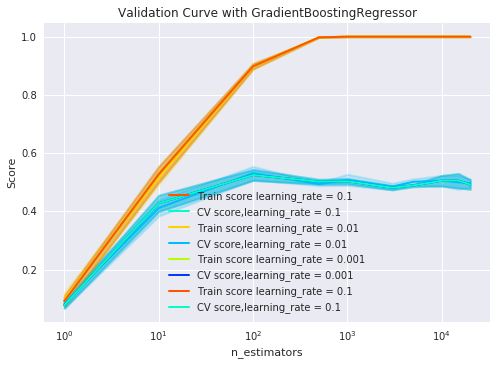

train_scores_mean
[ 0.09899296  0.51483979  0.8980877   0.99784559  0.99997138  1.          1.
  1.          1.          1.        ]
train_scores_std
[  2.28999112e-02   2.33370439e-02   9.57955882e-03   1.01826201e-04
   2.70126474e-06   1.70644981e-11   3.25959665e-15   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.08263709  0.4113415   0.53102394  0.49322982  0.5082465   0.48506338
  0.50152951  0.50508066  0.49951213  0.497219  ]
valid_scores_std
[ 0.01666899  0.02778424  0.02344511  0.00524138  0.0193648   0.01158869
  0.01032809  0.01816733  0.02400753  0.0135527 ]


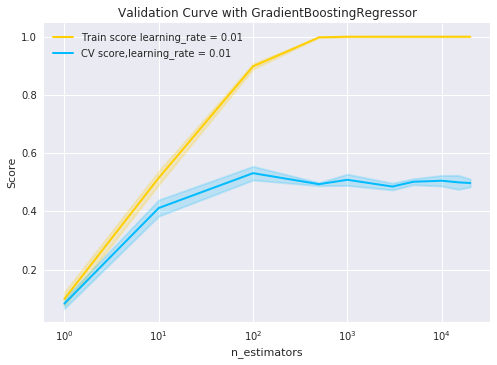

train_scores_mean
[ 0.09191764  0.52711342  0.89843481  0.99780754  0.99997314  1.          1.
  1.          1.          1.        ]
train_scores_std
[  1.83120545e-02   2.73031722e-02   9.33750591e-03   6.18246961e-05
   3.75728181e-06   1.03593075e-11   4.69192387e-15   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.07743459  0.42736726  0.5248057   0.50189519  0.50329067  0.48097222
  0.48895781  0.50508066  0.50532621  0.49227896]
valid_scores_std
[ 0.00993969  0.02794063  0.01867228  0.0080402   0.00866285  0.00705411
  0.00449608  0.01816733  0.02481479  0.01677837]


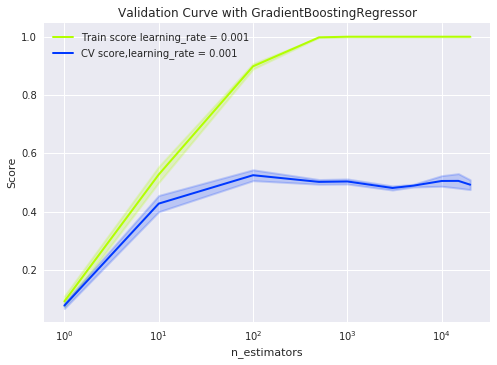

In [39]:
plot_validation_curve(train_scores_l1, valid_scores_l1, "learning_rate = 0.1", 1)
plot_validation_curve(train_scores_l2, valid_scores_l2, "learning_rate = 0.01", 2)
plot_validation_curve(train_scores_l3, valid_scores_l3, "learning_rate = 0.001", 3)

In [52]:
train_scores_d1, valid_scores_d1 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  5, 
                                                                               min_samples_leaf = 5, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)
train_scores_d2, valid_scores_d2 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                   
train_scores_d3, valid_scores_d3 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  15, 
                                                                               min_samples_leaf = 5, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                                                                      

train_scores_mean
[ 0.08181503  0.43504438  0.7832685   0.94151868  0.98269937  0.99960625
  0.99998532  0.99999999  1.          1.        ]
train_scores_std
[  1.59006560e-02   3.11917121e-02   2.22883633e-03   4.36381392e-03
   1.70697340e-03   4.63183539e-05   4.40195120e-06   3.95479718e-09
   5.77933946e-12   3.87254109e-15]
valid_scores_mean
[ 0.0744195   0.35993001  0.54655014  0.51435768  0.50697423  0.46512553
  0.4990423   0.48293203  0.48403642  0.4943072 ]
valid_scores_std
[ 0.02312503  0.05477379  0.02452635  0.00623362  0.01129905  0.02692908
  0.00776529  0.01340568  0.02020369  0.00739621]
train_scores_mean
[ 0.09543244  0.52704336  0.89855243  0.99789897  0.99996138  1.          1.
  1.          1.          1.        ]
train_scores_std
[  1.35311048e-02   2.20379405e-02   6.68603744e-03   2.86029062e-04
   6.91101805e-06   2.43718445e-10   2.82382485e-14   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.08257007  0.41352147  0.53270355  0.49639

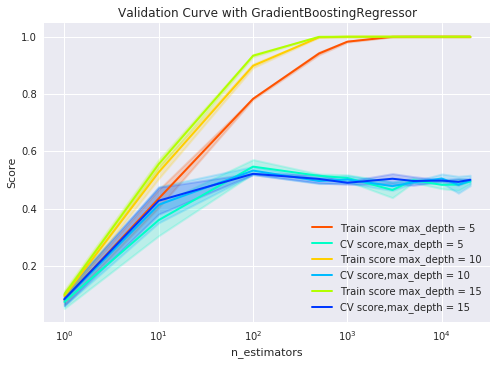

In [53]:
plot_validation_curve(train_scores_d1, valid_scores_d1, "max_depth = 5", 1)
plot_validation_curve(train_scores_d2, valid_scores_d2, "max_depth = 10", 2)
plot_validation_curve(train_scores_d3, valid_scores_d3, "max_depth = 15", 3)
plt.show()

In [54]:
param_range = [1, 10, 100, 500, 1000, 3000, 5000, 10000, 15000, 20000]

train_scores_s1, valid_scores_s1 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 3, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)
train_scores_s2, valid_scores_s2 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                   
train_scores_s3, valid_scores_s3 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 10, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                                                                      

train_scores_mean
[ 0.10750082  0.58267465  0.94393742  0.99980956  0.9999995   1.          1.
  1.          1.          1.        ]
train_scores_std
[  9.24641420e-03   5.26614709e-03   2.70930342e-03   3.66813674e-05
   4.06953314e-08   6.81379125e-16   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.0744195   0.35993001  0.54655014  0.51435768  0.50697423  0.46512553
  0.4990423   0.48293203  0.48403642  0.4943072 ]
valid_scores_std
[ 0.02312503  0.05477379  0.02452635  0.00623362  0.01129905  0.02692908
  0.00776529  0.01340568  0.02020369  0.00739621]
train_scores_mean
[ 0.10497827  0.53679221  0.89934217  0.99784057  0.99995926  1.          1.
  1.          1.          1.        ]
train_scores_std
[  6.32618283e-03   3.32485752e-02   7.73132117e-03   2.20797975e-04
   7.56592071e-06   8.10360335e-11   2.82382485e-14   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.08257007  0.41352147  0.53270355  0.49639872  0.5

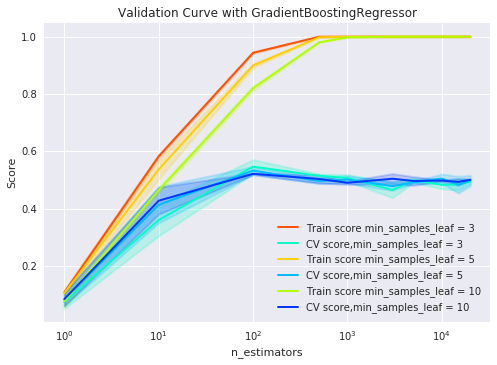

In [59]:
plot_validation_curve(train_scores_s1, valid_scores_d1, "min_samples_leaf = 3", 1)
plot_validation_curve(train_scores_s2, valid_scores_d2, "min_samples_leaf = 5", 2)
plot_validation_curve(train_scores_s3, valid_scores_d3, "min_samples_leaf = 10", 3)
plt.show()

In [62]:
train_scores_f1, valid_scores_f1 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.3, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)
train_scores_f2, valid_scores_f2 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.1, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                   
train_scores_f3, valid_scores_f3 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                                                                      

train_scores_mean
[ 0.11979792  0.57312521  0.81945456  0.97273014  0.99569585  0.99999218
  0.99999996  1.          1.          1.        ]
train_scores_std
[  4.99264531e-03   1.20639560e-02   8.89876565e-03   4.74771075e-03
   1.14057964e-03   2.49838049e-06   2.14067619e-08   2.62690193e-13
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.10873542  0.47772038  0.54097213  0.50520741  0.48323825  0.48964174
  0.48721911  0.47389512  0.48981767  0.48152879]
valid_scores_std
[ 0.01132883  0.03387765  0.01953898  0.00321958  0.01806011  0.01406962
  0.00695565  0.02003245  0.01417047  0.0097887 ]
train_scores_mean
[ 0.11480596  0.6001942   0.92113238  0.99869251  0.99996621  1.          1.
  1.          1.          1.        ]
train_scores_std
[  1.37579571e-03   4.91787810e-03   8.97030195e-03   5.50847415e-04
   1.03773333e-05   3.55443658e-11   4.53246652e-16   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.10133105  0.46909719  0.51974578  0.50946

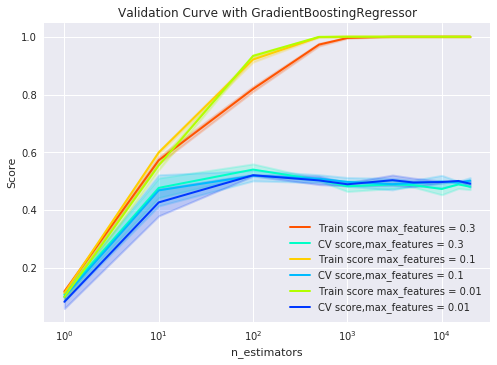

In [61]:
plot_validation_curve(train_scores_f1, valid_scores_f1, "max_features = 0.3", 1)
plot_validation_curve(train_scores_f2, valid_scores_f2, "max_features = 0.1", 2)
plot_validation_curve(train_scores_f3, valid_scores_f3, "max_features = 0.01", 3)
plt.show()

In [14]:
from sklearn.model_selection import validation_curve 
param_range = [1, 10, 100, 500, 1000, 3000, 5000, 10000, 15000, 20000]

train_scores_n1, valid_scores_n1 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.3, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)
train_scores_n2, valid_scores_n2 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.1, 
                                                                               max_leaf_nodes =  3, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                   
train_scores_n3, valid_scores_n3 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.01, 
                                                                               max_leaf_nodes =  5, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                                                                      

train_scores_mean
[ 0.12890545  0.61757874  0.93434481  0.99793833  0.99983965  0.99999966
  0.99999999  1.          1.          1.        ]
train_scores_std
[  1.07467100e-02   1.17450004e-02   7.92036930e-03   7.73547339e-04
   4.58375945e-05   3.47750827e-07   1.93347631e-08   9.42578912e-14
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.11462347  0.48689913  0.50829917  0.50487016  0.46908106  0.48531387
  0.48299911  0.47094244  0.47716869  0.47730237]
valid_scores_std
[ 0.00906324  0.02793985  0.02030866  0.01625999  0.01614863  0.00116554
  0.00669124  0.00912458  0.01545728  0.01963095]
train_scores_mean
[ 0.07511889  0.40553564  0.63909983  0.73586837  0.78641387  0.87447668
  0.91072251  0.95286709  0.97136791  0.98134968]
train_scores_std
[ 0.02132589  0.00852263  0.00427452  0.00442556  0.00779025  0.00747761
  0.00580987  0.00400528  0.0023718   0.00171309]
valid_scores_mean
[ 0.07300926  0.38359568  0.54167582  0.54110903  0.51802327  0.48219549
  0.45456076  0

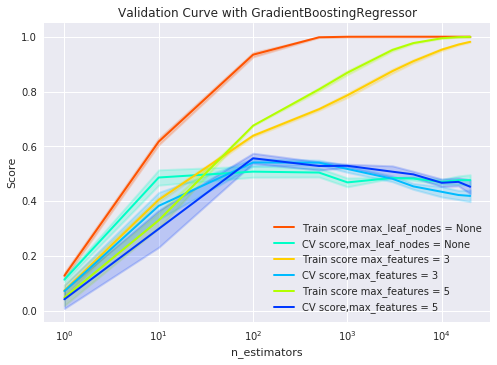

In [16]:
import matplotlib.pyplot as plt
plot_validation_curve(train_scores_n1, valid_scores_n1, "max_leaf_nodes = None", 1)
plot_validation_curve(train_scores_n2, valid_scores_n2, "max_features = 3", 2)
plot_validation_curve(train_scores_n3, valid_scores_n3, "max_features = 5", 3)
plt.show()

In [17]:
train_scores_b1, valid_scores_b1 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.3, 
                                                                               max_leaf_nodes =  None, subsample = 1.0), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)
train_scores_b2, valid_scores_b2 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.1, 
                                                                               max_leaf_nodes =  None, subsample = 0.5), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)                   
train_scores_b3, valid_scores_b3 = validation_curve(GradientBoostingRegressor(learning_rate = 0.1,max_depth =  10, 
                                                                               min_samples_leaf = 5, max_features = 0.01, 
                                                                               max_leaf_nodes =  None, subsample = 0.3), x_train_trn, y_train_reg,"n_estimators", param_range, n_jobs=-1)  

train_scores_mean
[ 0.14237503  0.71820914  0.97272881  0.99964299  0.9999956   1.          1.
  1.          1.          1.        ]
train_scores_std
[  2.61917045e-03   1.31051654e-02   4.28231991e-03   2.17723290e-04
   3.30389536e-06   7.13989205e-12   8.38200002e-16   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.1075531   0.47491503  0.51512508  0.50754851  0.49768102  0.49768252
  0.49774162  0.50090205  0.49389477  0.49668219]
valid_scores_std
[ 0.01068642  0.02508715  0.01270168  0.0108062   0.00992609  0.00921071
  0.00608458  0.01906163  0.01763014  0.01076286]
train_scores_mean
[ 0.12208813  0.59624843  0.92822141  0.99874632  0.99997725  1.          1.
  1.          1.          1.        ]
train_scores_std
[  9.70037489e-03   6.19042037e-03   5.80310518e-03   4.71997669e-04
   6.78209620e-06   2.18676942e-11   3.18822858e-15   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
valid_scores_mean
[ 0.10587568  0.47834674  0.51876807  0.49278963  0.4

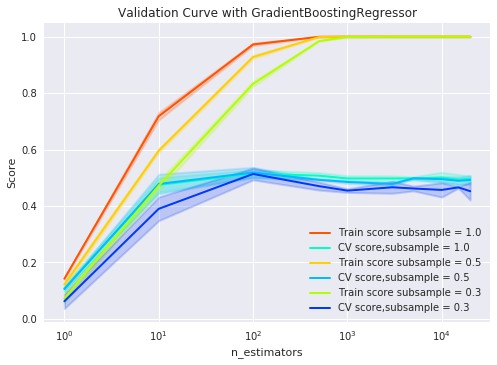

In [18]:
plot_validation_curve(train_scores_b1, valid_scores_b1, "subsample = 1.0", 1)
plot_validation_curve(train_scores_b2, valid_scores_b2, "subsample = 0.5", 2)
plot_validation_curve(train_scores_b3, valid_scores_b3, "subsample = 0.3", 3)
plt.show()